# **MedCoach - EDA & Baseline**
Dataset - [Diseases and their Symptoms](https://www.kaggle.com/datasets/shobhit043/diseases-and-their-symptoms)

## **EDA**

In [ ]:
!pip install transformers datasets scikit-learn pandas torch
!pip install evaluate
!pip install --upgrade transformers
!pip install --upgrade --no-cache-dir transformers

In [ ]:
import pandas as pd
from google.colab import drive
import subprocess
import random
import time
import os
from google.colab import files
import transformers
from sklearn.model_selection import train_test_split
from datasets import Dataset
import evaluate
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,TrainingArguments,Trainer,DataCollatorWithPadding)

In [ ]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/NLP/FInal_Train_Data.csv')

In [ ]:
df.head()

,Unnamed: 0,pain chest,shortness of breath,dizziness,asthenia,fall,syncope,vertigo,sweat sweating increased,palpitation,...,prodrome,hypoproteinemia,alcohol binge episode,abdomen acute,air fluid level,catching breath,large-for-dates fetus,immobile,homicidal thoughts,prognosis
0,0,0,1,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,hypertensive disease
1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,diabetes
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"depression mental , depressive disorder"
3,0,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"coronary arteriosclerosis ,coronary heart disease"
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,pneumonia


In [ ]:
df.shape

(2564, 402)

### **Duplicate rows**

In [ ]:
dup_mask = df.duplicated()
num_dupes = dup_mask.sum()
print(f"Found {num_dupes} duplicate row(s).")

Found 13 duplicate row(s).


In [ ]:
# Droping all duplicate rows
df = df.drop_duplicates().reset_index(drop=True)
print("New shape without duplicates:", df.shape)

New shape without duplicates: (2551, 402)


In [ ]:
# Save the dataset
df.to_csv("df_no_dups.csv", index=False)

### **Data statistics**

In [ ]:
feature_cols = [c for c in df.columns if c != 'prognosis']
df['ones_count'] = df[feature_cols].sum(axis=1)

stats = (
     df
     .groupby('prognosis')['ones_count']
     .agg(
         n_rows='count',                                   # how many rows per disease
         min_ones='min',                                   # smallest # of 1’s in any case
         max_ones='max',                                   # largest # of 1’s in any case
         range_ones=lambda x: x.max() - x.min(),           # difference between them
         avg_ones='mean'                                   # average # of 1’s per case
     ).reset_index())

stats['avg_ones'] = stats['avg_ones'].round(2)
stats

,prognosis,n_rows,min_ones,max_ones,range_ones,avg_ones
0,Alzheimer's disease,25,4,7,3,5.48
1,Pneumocystis carinii pneumonia,28,4,7,3,5.29
2,accident cerebrovascular,10,4,7,3,5.30
3,acquired immuno-deficiency syndrome HIV hiv in...,22,4,7,3,5.27
4,adenocarcinoma,19,4,7,3,5.58
...,...,...,...,...,...,...
128,tonic-clonic epilepsy tonic-clonic seizures,17,4,7,3,5.65
129,transient ischemic attack,25,4,7,3,5.64
130,tricuspid valve insufficiency,16,4,7,3,5.56
131,ulcer peptic,19,4,7,3,5.47


In [ ]:
# Count rows per disease
counts = df.groupby('prognosis').size().reset_index(name='n_rows')

# Compute overall average of those counts
avg_rows = counts['n_rows'].mean()

# Identify the max / min
max_idx = counts['n_rows'].idxmax()
min_idx = counts['n_rows'].idxmin()

most = counts.loc[max_idx]
fewest = counts.loc[min_idx]

print(counts)
print(f"\nAverage rows per disease: {avg_rows:.2f}")
print(f"Disease with most rows: {most['prognosis']} ({most['n_rows']} rows)")
print(f"Disease with fewest rows: {fewest['prognosis']} ({fewest['n_rows']} rows)")

                                             prognosis  n_rows
0                                  Alzheimer's disease      25
1                       Pneumocystis carinii pneumonia      28
2                             accident cerebrovascular      10
3    acquired immuno-deficiency syndrome HIV hiv in...      22
4                                       adenocarcinoma      19
..                                                 ...     ...
128        tonic-clonic epilepsy tonic-clonic seizures      17
129                          transient ischemic attack      25
130                      tricuspid valve insufficiency      16
131                                       ulcer peptic      19
132                        upper respiratory infection      43

[133 rows x 2 columns]

Average rows per disease: 19.18
Disease with most rows: bipolar disorder (43 rows)
Disease with fewest rows: decubitus ulcer (3 rows)


Adding a column that counts the number of symptoms

In [ ]:
feature_cols = [c for c in df.columns if c != 'prognosis']
df['ones_count'] = df[feature_cols].sum(axis=1)
df

,Unnamed: 0,pain chest,shortness of breath,dizziness,asthenia,fall,syncope,vertigo,sweat sweating increased,palpitation,...,hypoproteinemia,alcohol binge episode,abdomen acute,air fluid level,catching breath,large-for-dates fetus,immobile,homicidal thoughts,prognosis,ones_count
0,0,0,1,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,hypertensive disease,5
1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,diabetes,7
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"depression mental , depressive disorder",4
3,0,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,"coronary arteriosclerosis ,coronary heart disease",6
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,pneumonia,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,affect labile,5
2547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,affect labile,4
2548,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,affect labile,5
2549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,affect labile,5


Dropping single-value columns

In [ ]:
single_valued = [col for col in df.columns if df[col].nunique() == 1]
df.drop(columns=single_valued, inplace=True)

print("Dropped columns:", single_valued)
print("New shape:", df.shape)

Dropped columns: ['Unnamed: 0']
New shape: (2551, 402)


Distribution of diseases by number of symptoms

In [ ]:
dist = (
    df
    .groupby('ones_count')['prognosis']
    .count()
    .reset_index(name='n_diseases')
    .sort_values('ones_count'))

dist

,ones_count,n_diseases
0,3,1
1,4,643
2,5,639
3,6,618
4,7,650


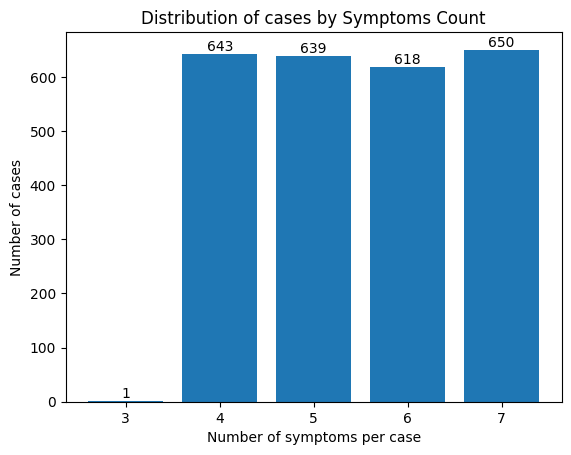

In [ ]:
import matplotlib.pyplot as plt

plt.bar(dist['ones_count'], dist['n_diseases'])

for x, y in zip(dist['ones_count'], dist['n_diseases']):
    plt.text(x, y, str(y), ha='center', va='bottom')

plt.xlabel('Number of symptoms per case')
plt.ylabel('Number of cases')
plt.title('Distribution of cases by Symptoms Count')
plt.xticks(dist['ones_count'])
plt.show()

Keeping rows with at least 4 symptoms

In [ ]:
df = df[df['ones_count'] >= 4].reset_index(drop=True)
print("New shape:", df.shape)

New shape: (2550, 402)


In [ ]:
df

,pain chest,shortness of breath,dizziness,asthenia,fall,syncope,vertigo,sweat sweating increased,palpitation,nausea,...,hypoproteinemia,alcohol binge episode,abdomen acute,air fluid level,catching breath,large-for-dates fetus,immobile,homicidal thoughts,prognosis,ones_count
0,0,1,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,hypertensive disease,5
1,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,diabetes,7
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"depression mental , depressive disorder",4
3,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,"coronary arteriosclerosis ,coronary heart disease",6
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,pneumonia,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,affect labile,5
2546,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,affect labile,4
2547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,affect labile,5
2548,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,affect labile,5


In [ ]:
dist = (
    df
    .groupby('ones_count')['prognosis']
    .count()
    .reset_index(name='n_diseases')
    .sort_values('ones_count'))

dist

,ones_count,n_diseases
0,4,643
1,5,639
2,6,618
3,7,650


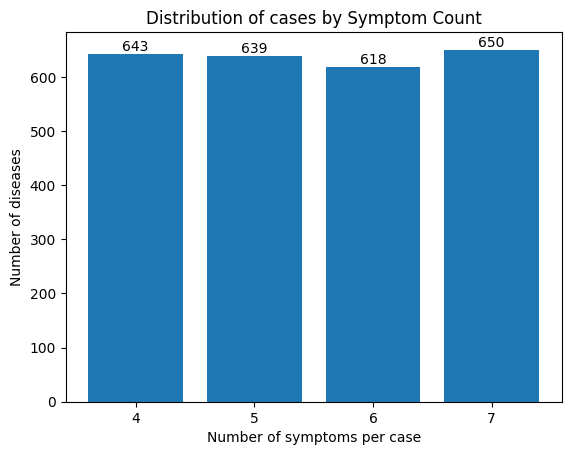

In [ ]:
import matplotlib.pyplot as plt

plt.bar(dist['ones_count'], dist['n_diseases'])

for x, y in zip(dist['ones_count'], dist['n_diseases']):
    plt.text(x, y, str(y), ha='center', va='bottom')

plt.xlabel('Number of symptoms per case')
plt.ylabel('Number of diseases')
plt.title('Distribution of cases by Symptom Count')
plt.xticks(dist['ones_count'])
plt.show()


## **Baseline**

Running the baseline for 100 random cases

In [ ]:
df_sample = df.sample(n=100, random_state=42).reset_index(drop=True)

In [ ]:
def install_ollama():
    global OLLAMA_MODEL
    try:
        subprocess.run("curl -fsSL https://ollama.com/install.sh | bash", shell=True, check=True)
        subprocess.Popen(["ollama", "serve"])
        time.sleep(10)
        subprocess.run(["ollama", "pull", "medllama2"], check=True)
        OLLAMA_MODEL = "medllama2"
    except:
        print("MedLlama2 failed. Falling back to LLaMA 3.2 3B...")
        subprocess.run(["ollama", "pull", "llama3.2:3b"], check=True)
        OLLAMA_MODEL = "llama3.2:3b"

## Generate patient cases using Ollama (medllama2)

In [ ]:
def call_ollama(disease: str, symptoms: list) -> dict:
    prompt = f"""
    Generate patient cases for a disease without naming the disease. Use age and gender based on common medical demographics. Return three cases separated by '|':
    - Full Case: All symptoms.
    - 80% Case: ~80% of symptoms.
    - 50% Case: ~50% of symptoms.
    Symptoms: {', '.join(symptoms)}
    Format: Full Case: ... | 80% Case: ... | 50% Case: ...
    Example: Full Case: A 60-year-old male presents with fever, cough, shortness of breath. | 80% Case: A 60-year-old male presents with fever, cough. | 50% Case: A 60-year-old male presents with fever.
    """
    try:
        result = subprocess.run(
            ["ollama", "run", OLLAMA_MODEL, prompt],
            capture_output=True, text=True, check=True
        )
        output = result.stdout.strip()
        full, eighty, fifty = output.split("|")
        return {
            "full_case": full.replace("Full Case:", "").strip(),
            "80_percent_case": eighty.replace("80% Case:", "").strip(),
            "50_percent_case": fifty.replace("50% Case:", "").strip()
        }
    except:
        # Fallback: Simple simulated response
        age = random.randint(20, 80)
        gender = random.choice(["male", "female"])
        half_symptoms = random.sample(symptoms, max(1, len(symptoms) // 2))
        eighty_symptoms = random.sample(symptoms, max(1, int(len(symptoms) * 0.8)))
        return {
            "full_case": f"A {age}-year-old {gender} presents with {', '.join(symptoms)}.",
            "80_percent_case": f"A {age}-year-old {gender} presents with {', '.join(eighty_symptoms)}.",
            "50_percent_case": f"A {age}-year-old {gender} presents with {', '.join(half_symptoms)}."
        }

In [ ]:
def process_dataset(df: pd.DataFrame) -> list:
    prognosis_col = "prognosis" if "prognosis" in df_sample.columns else "prognosis"
    exclude_cols = [prognosis_col, "ones_count"] if "ones_count" in df_sample.columns else [prognosis_col]
    symptom_cols = [col for col in df_sample.columns if col not in exclude_cols]

    dataset = []
    for _, row in df.iterrows():
        disease = row[prognosis_col]
        symptoms = [col.replace("symptom_", "").replace("_", " ") for col in symptom_cols if row[col] == 1]
        dataset.append({"disease": disease, "symptoms": symptoms})
    return dataset

In [ ]:
def generate_patient_cases(df: pd.DataFrame) -> pd.DataFrame:
    dataset = process_dataset(df)
    data = {"Disease": [], "Full_Case": [], "80_Percent_Case": [], "50_Percent_Case": []}

    for entry in dataset:
        data["Disease"].append(entry["disease"])
        case_data = call_ollama(entry["disease"], entry["symptoms"])
        data["Full_Case"].append(case_data["full_case"])
        data["80_Percent_Case"].append(case_data["80_percent_case"])
        data["50_Percent_Case"].append(case_data["50_percent_case"])

    return pd.DataFrame(data)

In [ ]:
if __name__ == "__main__":

    os.environ["OLLAMA_MODELS"] = "/content/drive/MyDrive/ollama_models"

    # Install Ollama
    install_ollama()

    # Generate cases
    result_df = generate_patient_cases(df_sample)

    result_df.to_csv("patient_cases.csv", index=False)
    files.download("patient_cases.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Patient cases generation evaluatiom (using PubMedBERT)

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
df = pd.read_csv('/content/patient_cases.csv')

In [ ]:
# Encode labels
labels = df['Disease'].unique().tolist()
label2id = {lbl:i for i,lbl in enumerate(labels)}
df['label'] = df['Disease'].map(label2id)

In [ ]:
def prepare_dataset(text_col):
    sub = df[[text_col, 'label']].rename(columns={text_col:'text'})
    train_df, val_df = train_test_split(sub, test_size=0.2, stratify=sub['label'], random_state=42)
    return Dataset.from_pandas(train_df), Dataset.from_pandas(val_df)

In [ ]:
MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label={i:l for l,i in label2id.items()},
    label2id=label2id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenization
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=512)

In [ ]:
# Training setup
data_collator = DataCollatorWithPadding(tokenizer)
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return metric.compute(predictions=preds, references=labels)

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./pubmedbert-diagnosis",

    eval_strategy="epoch",
    save_strategy="epoch",

    logging_steps=100,

    save_steps=200,
    save_total_limit=2,

    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,

    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)


def train_on(text_col, stage_name):
    print(f"\n>>> Training on {stage_name} ({text_col})")
    train_ds, val_ds = prepare_dataset(text_col)
    train_ds = train_ds.map(tokenize, batched=True)
    val_ds   = val_ds.map(tokenize, batched=True)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    metrics = trainer.evaluate()
    print(f"{stage_name} Eval Accuracy: {metrics['eval_accuracy']:.4f}")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# Runing PubMedBERT for three stages
train_on('50_Percent_Case', 'Stage 1 (50%)')
train_on('80_Percent_Case', 'Stage 2 (80%)')
train_on('Full_Case', 'Stage 3 (100%)')


>>> Training on Stage 1 (50%) (50_Percent_Case)


Map:   0%|          | 0/2040 [00:00<?, ? examples/s]

Map:   0%|          | 0/511 [00:00<?, ? examples/s]

<ipython-input-9-37d2954bb417>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,4.786100,4.511543,0.072407
2,4.277400,4.145812,0.142857
3,3.981700,4.032836,0.181996


Stage 1 (50%) Eval Accuracy: 0.1820

>>> Training on Stage 2 (80%) (80_Percent_Case)


Map:   0%|          | 0/2040 [00:00<?, ? examples/s]

Map:   0%|          | 0/511 [00:00<?, ? examples/s]

<ipython-input-9-37d2954bb417>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,3.672800,3.396950,0.336595
2,3.193900,3.072592,0.467710
3,2.883300,2.945481,0.493151


Stage 2 (80%) Eval Accuracy: 0.4932

>>> Training on Stage 3 (100%) (Full_Case)


Map:   0%|          | 0/2040 [00:00<?, ? examples/s]

Map:   0%|          | 0/511 [00:00<?, ? examples/s]

<ipython-input-9-37d2954bb417>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,2.497800,2.266370,0.700587
2,2.006300,1.891284,0.771037
3,1.713500,1.763652,0.786693


Stage 3 (100%) Eval Accuracy: 0.7867
